In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sys, os, time
sys.path.append('/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj')
import trajCellPoseSr
import h5py
import pickle
import subprocess
import re
import scipy
import string, itertools
from scipy import stats
from scipy.integrate import simps
from datetime import date
import seaborn as sns
import pandas as pd

In [2]:
trajl = 40
nstates_init = 7
nPCs = 10
nUMP = 0
wellInfo = 'A'
today = date.today()
date2day = today.strftime("%b%d-%Y")
figid = 'LI204601_P_tlen'+str(trajl)+'_'+date2day+'_nS'+str(nstates_init) 
datapath = '/home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/bulkRNAseq/scripts'
seqFile0 = 'MDDligandCombRNAseqLog2TPM_proteinCoding.csv'
seqData0 = pd.read_csv(datapath+'/'+seqFile0)

In [3]:
# Create a filter for log2(TPM) > 0.5 
ind_minexpr = np.where(np.sum(seqData0.iloc[:, 3:] > 0.5, axis=1) >= 3)[0]
geneNames0 = seqData0['hgnc_symbol']
ind_nan = np.where(np.logical_not(pd.isna(seqData0['hgnc_symbol'])))[0] # also genes with names
ensembl_gene_id0 = seqData0['ensembl_gene_id']
ind_expressed = np.intersect1d(ind_minexpr, ind_nan) # Indices of genes that are expressed (excluding NaN value members)
gene_names = geneNames0[ind_expressed] # Genes that are expressed
ensembl_gene_ids = ensembl_gene_id0[ind_expressed]

In [4]:
# read in DEseq2 files
cond0 = ['OSM','EGF','EGFTGFB','TGFB','PBS','OSMTGFBEGF','OSMEGF','OSMTGFB']
ncond0 = len(cond0)
deseq0 = [None]*ncond0
for icond in range(ncond0):
    seqfile = f'analysis_R/deseq2_DE_lfcshrink_ligands_{cond0[icond]}_vs_CTRL.csv'
    deseq0[icond] = pd.read_csv(datapath+'/'+seqfile)

In [5]:
# now match the genes in the two datasets together, we will do into protein coding nGenes0
nGenes0 = ind_expressed.size
inds_dataset0 = np.zeros(ncond0).astype(int)
inds_dataset = inds_dataset0
inds0 = np.where(inds_dataset == 0)[0]
nsamples = inds_dataset.size
x_lfc = np.ones((nsamples, nGenes0))*np.nan # logarithmic fold change
x_padj = np.ones((nsamples, nGenes0))*np.nan
seq_genes0 = deseq0[0]['Unnamed: 0']

In [6]:
for i in range(nGenes0):
    if i%100 == 0:
        print(f'matching gene {str(i)} of {str(nGenes0)}')
    gene_name = ensembl_gene_ids.iloc[i]
    indgene1 = np.where(seq_genes0 == gene_name)[0] 
    if indgene1.size > 0:
        for icond in range(ncond0):
            lfc = deseq0[icond].iloc[ind_expressed[i]]['log2FoldChange']
            padj = deseq0[icond].iloc[ind_expressed[i]]['padj']
            x_lfc[inds0[icond], i] = lfc
            x_padj[inds0[icond], i] = padj
tmSet = cond0 
nLigConds = len(tmSet)
sctm = trajCellPoseSr.cellPoseTraj()

matching gene 0 of 14577
matching gene 100 of 14577
matching gene 200 of 14577
matching gene 300 of 14577
matching gene 400 of 14577
matching gene 500 of 14577
matching gene 600 of 14577
matching gene 700 of 14577
matching gene 800 of 14577
matching gene 900 of 14577
matching gene 1000 of 14577
matching gene 1100 of 14577
matching gene 1200 of 14577
matching gene 1300 of 14577
matching gene 1400 of 14577
matching gene 1500 of 14577
matching gene 1600 of 14577
matching gene 1700 of 14577
matching gene 1800 of 14577
matching gene 1900 of 14577
matching gene 2000 of 14577
matching gene 2100 of 14577
matching gene 2200 of 14577
matching gene 2300 of 14577
matching gene 2400 of 14577
matching gene 2500 of 14577
matching gene 2600 of 14577
matching gene 2700 of 14577
matching gene 2800 of 14577
matching gene 2900 of 14577
matching gene 3000 of 14577
matching gene 3100 of 14577
matching gene 3200 of 14577
matching gene 3300 of 14577
matching gene 3400 of 14577
matching gene 3500 of 14577
matc

In [7]:
inds_finite = np.where(np.isfinite(np.sum(x_lfc, axis=0)))[0]
x_lfc = x_lfc[:, inds_finite]
x_padj = x_padj[:, inds_finite]
gene_names = gene_names.iloc[inds_finite]
ensembl_gene_ids = ensembl_gene_ids.iloc[inds_finite]
Xpca, pca = sctm.get_pca_fromdata(x_lfc, var_cutoff = .95)
colorSet = ['gray', 'gold', 'red', 'blue', 'orange', 'green', 'purple', 'brown',
            'gray', 'gold', 'lightblue', 'red', 'lightgreen', 'darkred', 'green']

visual = False
if visual:
    plt.figure(figsize = (8, 6))
    from adjustText import adjust_text
    texts = [None]*Xpca.shape[0]
    for i in range(nLigConds):
        plt.scatter(Xpca[i, 0], Xpca[i, 1], s = 50, c = colorSet[i])
        text = plt.text(Xpca[i, 0], Xpca[i, 1], tmSet[i], color = colorSet[i])
        texts[i] = text
    plt.xlabel('PCA1'); plt.ylabel('PCA2')
    adjust_text(texts, arrowprops=dict(arrowstyle = '->', color='black'))
    plt.pause(.1)

In [8]:
# get morphodynamical state probabilities from imaging analysis: To Change
stProbFile = 'stProbs_LI204601_P_tlen'+str(trajl)+'_nS'+str(nstates_init)+'pc'+str(nPCs)+'u'+str(nUMP)+wellInfo+'wellsComb.dat' 

if not stProbFile:
  print("ERROR in reading state probability file")
  sys.exit(0)

In [9]:
state_probs_ = np.loadtxt(stProbFile)
tmSet_imaging = np.array(['OSM','EGF','EGFTGFB','TGFB','PBS','OSMTGFBEGF','OSMEGF','OSMTGFB',
                          'PBS1','EGF1','OSM1','TGFB1','OSMEGF1'])
tmfSet = tmSet #so much fun with names
inds_tmfSet_imaging = np.array([]).astype(int)
for imf in range(len(tmfSet)):
    tm = tmfSet[imf]
    inds_tmfSet_imaging = np.append(inds_tmfSet_imaging, np.where(tmSet_imaging == tm)[0])

inds_tmfSet_Imaging = inds_tmfSet_imaging
state_probs_ = state_probs_[inds_tmfSet_imaging, :]
print("List of all conditions:", np.array(tmSet)[inds_tmfSet_imaging]) # Test + training sets

List of all conditions: ['OSM' 'EGF' 'EGFTGFB' 'TGFB' 'PBS' 'OSMTGFBEGF' 'OSMEGF' 'OSMTGFB']


In [10]:
def get_predictedFC(state_probs_test, statesFC):
    n_test = state_probs_test.shape[0]
    nStates = state_probs_test.shape[1]
    nGenes = statesFC.shape[1]
    x_FC_predicted = np.ones((n_test, nGenes))*np.nan
    
    for itr in range(n_test):
        statep = state_probs_test[itr, :]
        x_FC_predicted[itr, :] = (np.tile(statep, (nGenes, 1))*statesFC.T).sum(-1)
    
    return x_FC_predicted

In [11]:
def get_state_decomposition(x_fc, state_probs, ncombinations=500, inds_tm_training=None,
                            save_file=None, visual=False, verbose=True, nchunk=100, gene_names=None):
    nStates = state_probs.shape[1] # number of morphodynamic states
    ntr = state_probs.shape[0] # training set conditions
    nGenes = x_fc.shape[1]
    ntr_measured = x_fc.shape[0] # log-fold change values of RNA levels corresponding to training set
    if nStates > ntr:
        print(f'error, more states than conditions in state probabilities')
        return
    if nStates > ntr_measured:
        print(f'error, more states than measured bulk conditions')
        return
    x_fc_states = np.ones((nStates, nGenes))*np.nan
    if inds_tm_training is None:
        inds_tm_training = np.arange(ntr).astype(int)
    ntr_training = inds_tm_training.size
    comb_trainarray = np.array(list(itertools.combinations(inds_tm_training, nStates)))
    ncomb = comb_trainarray.shape[0]
    print(f'{ncomb} possible combinations of {ntr} training measurements decomposed into {nStates} states')
    if ncombinations > ncomb:
        ncombinations = ncomb
    print(f'using {ncombinations} of {ncomb} possible training set combinations randomly per feature')
    for ig in range(nGenes): # LOOP OVER NUMBER OF GENES
        # Generate a uniform random sequence from np.arange(ncomb) of size "ncombinations"
        indr = np.random.choice(ncomb, ncombinations, replace=False)
        if ig%nchunk == 0 and verbose:
            print(f'decomposing gene {ig} of {nGenes}')
            if save_file is not None:
                np.save(save_file, x_fc_states)
        v_states_comb = np.zeros((ncombinations, nStates))
        for icomb in range(ncombinations):
            indcomb = comb_trainarray[indr[icomb]] # Pick randomized index to remove bias 
            v_treatments = x_fc[indcomb, ig] # Pick a ligand condition randomly and use its RNA levels
            # Least square linear optimization for each Gene --> solving state_probs*x = v_treatments (fold-change)  
            res = scipy.optimize.lsq_linear(state_probs[indcomb, :], v_treatments, bounds=(lb, ub), verbose=1)
            v_states_comb[icomb, :] = res.x.copy() # x (contribution of each state) is returned from scipy.optimize.lsq_linear 
        v_states = np.mean(v_states_comb, axis=0)
        x_fc_states[:, ig] = v_states.copy() # log-fold change of a selected gene across morphodynamic states
        if ig%nchunk == 0 and visual:
            plt.clf()
            plt.plot(v_states_comb.T, 'k.')
            plt.plot(v_states.T, 'b-', linewidth=2)
            if gene_names is None:
                plt.title(f'{ig} of {nGenes}')
            else:
                plt.title(str(gene_names.iloc[ig])+' gene '+str(ig)+' of '+str(nGenes))
            plt.pause(.1)
    if save_file is not None:
        np.save(save_file, x_fc_states)
    return x_fc_states

MODIFY INDICES AND DATA ACCORDING TO WHETHER A CONDITION IS EXCLUDED FROM TRAINING

In [12]:
loco = True
iTest = 5    
inds_tm_training = np.arange(nLigConds).astype(int) 
inds_tm_test = np.array([iTest]).astype(int) # leaving one "LIGAND" condition out (LOCO), just test from combo data
LOCO = tmSet_imaging[inds_tm_test]
LOCO = ''.join(LOCO) # convert string list to string
inds_tm_training = np.setdiff1d(inds_tm_training, inds_tm_test) # remove LOCO index from the training set
############# Update state probabilities and log-fold change values as per "inds_tm_training" #############
state_probs_loco = state_probs_[inds_tm_training, :]
x_lfc_loco = x_lfc[inds_tm_training, :]
inds_tmfSet_imaging = np.arange(len(inds_tm_training), dtype = int)
inds_tm_training = inds_tmfSet_imaging # Update training indices after LOCO
state_probs = state_probs_loco[inds_tmfSet_imaging, :] # state probabilities of the training set
nStates = state_probs.shape[1] # Number of Macroscopic (morphodynamic) states 
ntr = state_probs.shape[0] # Number of training conditions 
state_probs = state_probs[inds_tmfSet_imaging, 0:nStates]
seq_genes = gene_names.reset_index(drop = True)
ntr_training = inds_tm_training.size
lb = np.zeros(nStates)
ub = np.ones(nStates)*np.inf

In [13]:
%%capture
# First pass, just with training set
nGenes = x_lfc.shape[1]
# Element-wise raise 2 to the power of x_lfc --> Eliminate Log @ base 2
x_fc = 2**x_lfc_loco # Log-fold change values of training set
x_fc_all = 2**x_lfc # Log-fold change values of test & training sets
        
x_fc_states = get_state_decomposition(x_fc, state_probs, ncombinations=500, inds_tm_training=inds_tm_training, 
                                      save_file=None, visual=visual, gene_names=gene_names)

In [14]:
%%capture
# Predict fold-change values of the test set whereas the model was trained on remaining conditions (training set)
state_probs_LOCO = state_probs_[inds_tm_test, 0:nStates] # State probabilities of the "Test Set"
x_fc_predicted = get_predictedFC(state_probs_LOCO, x_fc_states)
x_lfc_predicted = np.log2(x_fc_predicted) # Convert from fold-change to log fold-change
       
print(f'{tmSet[iTest]} corr: {np.corrcoef(x_lfc[iTest, :], x_lfc_predicted[0, :])[0, 1]:.2f}')
    
nConds_test = len(inds_tm_test) # Number of Ligand conditions in "Test Set"

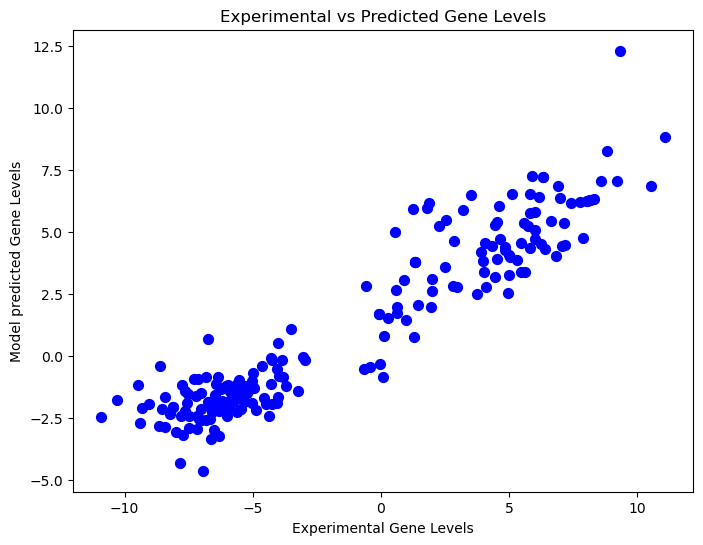

In [18]:
topVariableGenes = 200

# get list of most top 5000 highly variable genes
gvars = np.std(x_lfc, axis=0)
indvar = np.argsort(gvars)[-topVariableGenes:]
gene_inds = gene_names.iloc[indvar]

"""
plt.figure(figsize=(10, 16))  # Adjust the size as needed
# Create a DataFrame from arrays to create a heatmap 
data = pd.DataFrame({'Gene': gene_inds,
                     'Experimental': x_lfc[inds_tm_test, indvar].T,
                     'Predicted': x_lfc_predicted[:, indvar].T.flatten() })
# Aggregate the data by taking the mean
data_agg = data.groupby('Gene').mean().reset_index()
# Create a "long-form" DataFrame suitable for sns.heatmap
data_long = pd.melt(data_agg, id_vars=['Gene'], value_vars=['Experimental', 'Predicted'])
heatmap = sns.heatmap(data_long.pivot('Gene', 'variable', 'value'), cmap="viridis", annot=True, vmin=-10, vmax=10)
# Customize the heatmap as needed
heatmap.set_title('Heatmap of Experimental vs Predicted Gene Levels')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
"""
exp_gene_level =  x_lfc[inds_tm_test, indvar].T
model_pred_gene_level =  x_lfc_predicted[:, indvar].T.flatten()
plt.figure(figsize=(8, 6))  # Adjust the size as needed
### Plot scatter plot of model predicted vs Experimental values of gene levels 
plt.scatter(exp_gene_level, model_pred_gene_level, s = 50, c='blue')
plt.title('Experimental vs Predicted Gene Levels')
plt.ylabel('Model predicted Gene Levels')
plt.xlabel('Experimental Gene Levels')

#plt.savefig(figid+'_LOCO_genePred_PC'+str(nPCs)+'u'+str(nUMP)+wellInfo+'wellsCombOSMEGFTGFB.png')
plt.show()

In [ ]:
plt.clf()
plt.figure(figsize = (9, 6))
ax = plt.gca()
for iTest in range(nLigConds):
    
    inds_tm_training = np.arange(nLigConds).astype(int) 
    inds_tm_test = np.array([iTest]).astype(int) # leaving one "LIGAND" condition out (LOCO), just test from combo data
    LOCO = tmSet_imaging[inds_tm_test]
    LOCO = ''.join(LOCO) # convert string list to string
    inds_tm_training = np.setdiff1d(inds_tm_training, inds_tm_test) # remove LOCO index from the training set
    ############# Update state probabilities and log-fold change values as per "inds_tm_training" #############
    state_probs_loco = state_probs_[inds_tm_training, :]
    x_lfc_loco = x_lfc[inds_tm_training, :]
    inds_tmfSet_imaging = np.arange(len(inds_tm_training), dtype = int)
    inds_tm_training = inds_tmfSet_imaging # Update training indices after LOCO
    state_probs = state_probs_loco[inds_tmfSet_imaging, :] # state probabilities of the training set
    nStates = state_probs.shape[1] # Number of Macroscopic (morphodynamic) states 
    ntr = state_probs.shape[0] # Number of training conditions 
    state_probs = state_probs[inds_tmfSet_imaging, 0:nStates]
    seq_genes = gene_names.reset_index(drop = True)
    ntr_training = inds_tm_training.size
    lb = np.zeros(nStates)
    ub = np.ones(nStates)*np.inf
    
    # First pass, just with training set
    nGenes = x_lfc.shape[1]
    # Element-wise raise 2 to the power of x_lfc --> Eliminate Log @ base 2
    x_fc = 2**x_lfc_loco # Log-fold change values of training set
    x_fc_all = 2**x_lfc # Log-fold change values of test & training sets
        
    get_counts = True
    if get_counts:
        x_fc_states = get_state_decomposition(x_fc, state_probs, ncombinations=500, inds_tm_training=inds_tm_training, 
                                              save_file=None, visual=visual, gene_names=gene_names)
                                              #save_file='statefc_production_'+figid+'_'+LOCO+'.npy', visual=visual, gene_names=gene_names)
    else:
        x_fc_states = np.load('statefc_production_'+figid+LOCO+'.npy')
             
    # Predict fold-change values of the test set whereas the model was trained on remaining conditions (training set)
    state_probs_LOCO = state_probs_[inds_tm_test, 0:nStates] # State probabilities of the "Test Set"
    x_fc_predicted = get_predictedFC(state_probs_LOCO, x_fc_states)
    x_lfc_predicted = np.log2(x_fc_predicted) # Convert from fold-change to log fold-change
       
    print(f'{tmSet[iTest]} corr: {np.corrcoef(x_lfc[iTest, :], x_lfc_predicted[0, :])[0, 1]:.2f}')
    
    nConds_test = len(inds_tm_test) # Number of Ligand conditions in "Test Set"
        
    # get list of most top 5000 highly variable genes
    gvars = np.std(x_lfc, axis=0)
    indvar = np.argsort(gvars)[-topVariableGenes:]
    tick_genes = gene_names.iloc[indvar][-nticks:]
    df_cond = pd.DataFrame(data=x_lfc[:, indvar].T, index=gene_names.iloc[indvar], columns=tmSet)
    hmap = sns.clustermap(df_cond, cmap="seismic", cbar_kws={'label': 'log2 fold-change'},
                          cbar_pos=None, col_cluster=False, vmin=-10, vmax=10)
    reord_inds = hmap.dendrogram_row.reordered_ind.copy()
    tick_locs = np.zeros(nticks)
    for itick in range(nticks):
        tick_locs[itick] = np.where(seq_genes[indvar[reord_inds]] == tick_genes.iloc[itick])[0][0]+.5
        hmap.ax_heatmap.set_yticks(tick_locs)
        hmap.ax_heatmap.set_yticklabels(tick_genes)
        plt.setp(hmap.ax_heatmap.get_xticklabels(), rotation=40)
        plt.pause(.1)
#plt.savefig(figid+'_LOCO_correlationsPC'+str(nPCs)+'u'+str(nUMP)+wellInfo+'wellsComb.png')
plt.show()